# Combine Monthly EVI data from NASA's LP DAAC into a single dataset

Temporal support: monthly, 2014--2020 <br>
Spaital support: 0.05-deg, global

https://doi.org/10.5067/MODIS/MOD13C2.006 <br>
https://lpdaac.usgs.gov/

NOTE: Use `geopy` conda environment.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

from datetime import datetime
import xarray as xr
import rioxarray
import data_utils

%matplotlib inline

In [3]:
extents = [-130, 18, -60, 62] # [minx, miny, maxx, maxy]
ds_pre = (
    xr.open_dataset(
        "../data/exp_raw/MOD13C2.A2015244.006.2015307062406.hdf", 
        engine="rasterio", 
        variable="CMG 0.05 Deg Monthly EVI",
        mask_and_scale=True,
    )
    .squeeze()
    .rio.clip_box(*extents)
)

In [4]:
ds = xr.Dataset(
        {"evi": (["lon", "lat"], ds_pre["CMG 0.05 Deg Monthly EVI"].T.values)},
        coords={
            "lon": (["lon"], ds_pre.x.values),
            "lat": (["lat"], ds_pre.y.values),
            "time": datetime.fromisoformat(ds_pre.RANGEBEGINNINGDATE),
        },
    )
ds

<xarray.Dataset>
Dimensions:  (lon: 1400, lat: 880)
Coordinates:
  * lon      (lon) float64 -130.0 -129.9 -129.9 -129.8 ... -60.12 -60.07 -60.02
  * lat      (lat) float64 61.97 61.92 61.88 61.83 ... 18.17 18.12 18.08 18.02
    time     datetime64[ns] 2015-09-01
Data variables:
    evi      (lon, lat) float32 2.023e+07 2.6e+07 2.76e+07 ... nan nan nan

In [7]:
# Aggregate grid to plot
extents = [-125, -65, 22, 58]
grid_def = data_utils.set_grid_def(lon_res=5, lat_res=4)
lon_lwr, lon_upr, lat_lwr, lat_upr = data_utils.prep_extents(extents, grid_def)
df = ds.to_dataframe().reset_index()
bounds = (
    (df.lon >= lon_lwr)
    & (df.lon <= lon_upr)
    & (df.lat >= lat_lwr)
    & (df.lat <= lat_upr)
)
# drop data outside domain extents so it's not included in edge bin averages
df = df.loc[bounds].reset_index()
df_grid = data_utils.regrid(df=df, extents=extents, grid_def=grid_def)
if "index" in df_grid.columns:
        df_grid = df_grid.drop(columns="index")

df_grid = data_utils.monthly_avg(df_grid)

In [8]:
ds_grid = df_grid.set_index(["lon", "lat", "time"]).to_xarray()
ds_grid

<xarray.Dataset>
Dimensions:  (lon: 13, lat: 10, time: 1)
Coordinates:
  * lon      (lon) float64 -125.0 -120.0 -115.0 -110.0 ... -75.0 -70.0 -65.0
  * lat      (lat) float64 22.0 26.0 30.0 34.0 38.0 42.0 46.0 50.0 54.0 58.0
  * time     (time) datetime64[ns] 2015-09-01
Data variables:
    evi      (lon, lat, time) float32 nan nan nan ... 2.499e+07 2.37e+07

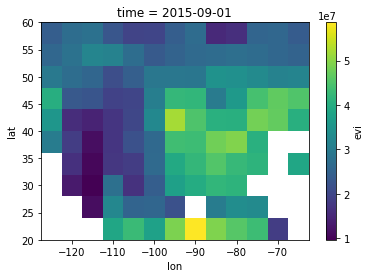

In [9]:
ds_grid.evi.T.plot()

In [17]:
with xr.open_dataset(
        "../data/exp_raw/MOD13C2.A2015244.006.2015307062406.hdf", 
        engine="rasterio", 
        variable="CMG 0.05 Deg Monthly EVI",
        mask_and_scale=True,
    ) as ds:
    prep = data_utils.prep_evi(ds)

In [18]:
prep

<xarray.Dataset>
Dimensions:  (lon: 7200, lat: 3600)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * lat      (lat) float64 89.97 89.92 89.88 89.83 ... -89.88 -89.93 -89.98
    time     datetime64[ns] 2015-09-01
Data variables:
    evi      (lon, lat) float32 nan nan nan nan nan nan ... nan nan nan nan nan